###  Notebook Objective
This notebook provides an end-to-end overview of how credit scorecards work, covering key steps such as data processing, feature engineering, model building, and evaluation. While it walks through the fundamental concepts and methodologies, there is always more that can be done—from refining models and incorporating additional risk factors to aligning with business strategies and regulatory requirements.

We'll be using the Toad package to streamline parts of the scorecard development process. While Toad offers useful automation, it may not be as flexible or customizable as coding these steps manually. The goal is to build a solid understanding of the credit scoring process while recognizing that real-world applications may extend beyond what is covered here.

In [13]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

from sklearn.preprocessing import LabelEncoder


import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr


from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve 

import warnings
warnings.filterwarnings('ignore')

In [82]:
df=pd.read_csv('')

ModuleNotFoundError: No module named 'kagglehub'

In [81]:
df.head()

,<!DOCTYPE html>
0,"<html lang=""en"">"
1,<head>
2,<title>Lending_Club | Kaggle</title>
3,"<meta charset=""utf-8"" />"
4,"<meta name=""description"" content=""Kaggle is ..."


In [15]:
def clean_data(df):
 
    
    ## cols to be dropped
    #'Unnamed: 0'> index to be used
    #'id', 'member_id'> not relevant in creating score card
    #funded_amnt, funded_amnt_inv same as loan amount. To be removed to avoid multicollinearity
    #grade to be dropped as sub-grade is a subset of grade
    #drop title as the purpose column will suffice
    #text attributes to be removed ['url']
    #policy code and application_type have only one unique value
    #last_pymnt_d can't be used during application
    #total_pymnt ,total_pymnt_inv are the same.total_pymnt_inv to be removed
    #emp_title
    
    df.drop(df[['Unnamed: 0','id','member_id','funded_amnt','funded_amnt_inv',
            'grade','url','application_type','title','policy_code','emp_title',
                'pymnt_plan','last_pymnt_d','last_pymnt_amnt','total_pymnt_inv','zip_code','addr_state']],
            axis=1,inplace=True)
    
     #Drop columns with  70% N/A of the data:
    df.dropna(axis='columns', thresh=0.7*len(df),inplace=True)
    
    df['emp_length'].replace({ '10+ years': 10, '< 1 year': 0, '1 year': 1,'2 years': 2,'3 years': 3,'4 years': 4,
    '5 years': 5,'6 years': 6,'7 years': 7,'8 years': 8,'9 years': 9},inplace=True)
    
    
    # Calculate mode of the column
    mode_value = df['emp_length'].mode()[0]

    # Replace missing values with mode
    df['emp_length'] = df['emp_length'].fillna(mode_value)
    
    # Replace all numerical values where NA with -9999
    df[df.select_dtypes(include=['int64', 'float64']).columns] = df.select_dtypes(include=['int64', 'float64']).fillna(-9999)
    
    
    return df

df=clean_data(df)

In [16]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,36 months,10.65,162.87,B2,10.0,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,27.65,0.0,Jan-85,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5000.00,861.07,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0
1,2500,60 months,15.27,59.83,C4,0.0,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,1.00,0.0,Apr-99,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,456.46,435.17,0.00,117.08,1.11,Sep-13,0.0,0.0,-9999.0,-9999.0,-9999.0
2,2400,36 months,15.96,84.33,C5,10.0,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,8.72,0.0,Nov-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,2400.00,603.65,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0
3,10000,36 months,13.49,339.31,C1,10.0,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,20.00,0.0,Feb-96,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,10000.00,2209.33,16.97,0.00,0.00,Jan-15,0.0,0.0,-9999.0,-9999.0,-9999.0
4,3000,60 months,12.69,67.79,B5,1.0,RENT,80000.0,Source Verified,Dec-11,Current,other,17.94,0.0,Jan-96,0.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,2233.10,1009.07,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0


In [50]:
df.shape

(238913, 39)

In [17]:
def feat_eng(df):
    # credit history tenure
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
    df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
    
    

    df['credit_history_tenure_years']=(df['issue_d']-df['earliest_cr_line']).dt.days / 365.25
    df['credit_history_tenure_months'] = (df['issue_d'].dt.to_period('M') - df['earliest_cr_line'].dt.to_period('M'))
    df['credit_history_tenure_months'] = df['credit_history_tenure_months'].apply(lambda x: x.n if x is not pd.NaT else 0)


    df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month

    # Months between issue
    df['credit_pull_months'] = (df['issue_d'].dt.to_period('M') - df['last_credit_pull_d'].dt.to_period('M'))
    df['credit_pull_months'] = df['credit_pull_months'].apply(lambda x: x.n if x is not pd.NaT else 0)
    
    
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']
    

    df.drop(['earliest_cr_line','last_credit_pull_d','last_credit_pull_d'],axis=1,inplace=True)
    return df

df=feat_eng(df)

In [18]:
def good_bad(df):
    
    # assign 0 to bad loans(default) and 1 to good loans
    
    #bad loans
    condition=np.isin(df['loan_status'],['Charged Off','Late (31-120 days)','Late (16-30 days)','Default','Does not meet the credit policy. Status:Charged Off'])
    replace=['0']
    df['loan_status']=np.where(condition,replace,df['loan_status'])
    
    #good loans
    condition2=np.isin(df['loan_status'],['Fully Paid','Does not meet the credit policy. Status:Fully Paid'],)
    replace=['1']
    df['loan_status']=np.where(condition2,replace,df['loan_status'])
    
    ## I will drop status In Grace Period and Current because we are not sure if they will repay the loans or not
    values_to_drop = ['In Grace Period', 'Current']
    df = df[~df['loan_status'].isin(values_to_drop)]
    
    return df


df=good_bad(df)

In [19]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,credit_history_tenure_years,credit_history_tenure_months,earliest_cr_line_month,credit_pull_months,loan_to_income_ratio
0,5000,36 months,10.65,162.87,B2,10.0,RENT,24000.0,Verified,2011-12-01,1,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5000.00,861.07,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,26.913073,323,1.0,-49,0.208333
1,2500,60 months,15.27,59.83,C4,0.0,RENT,30000.0,Source Verified,2011-12-01,0,car,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,456.46,435.17,0.00,117.08,1.11,0.0,0.0,-9999.0,-9999.0,-9999.0,12.668036,152,4.0,-21,0.083333
2,2400,36 months,15.96,84.33,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,1,small_business,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,2400.00,603.65,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,10.080767,121,11.0,-49,0.195886
3,10000,36 months,13.49,339.31,C1,10.0,RENT,49200.0,Source Verified,2011-12-01,1,other,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,10000.00,2209.33,16.97,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,15.830253,190,2.0,-37,0.203252
5,5000,36 months,7.90,156.46,A4,3.0,RENT,36000.0,Source Verified,2011-12-01,1,wedding,11.20,0.0,3.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5000.00,631.38,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,7.080082,85,11.0,-45,0.138889


In [20]:
df['loan_status'].value_counts()

loan_status
1    186727
0     52186
Name: count, dtype: int64

In [21]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['loan_status'] = pd.to_numeric(df['loan_status'])

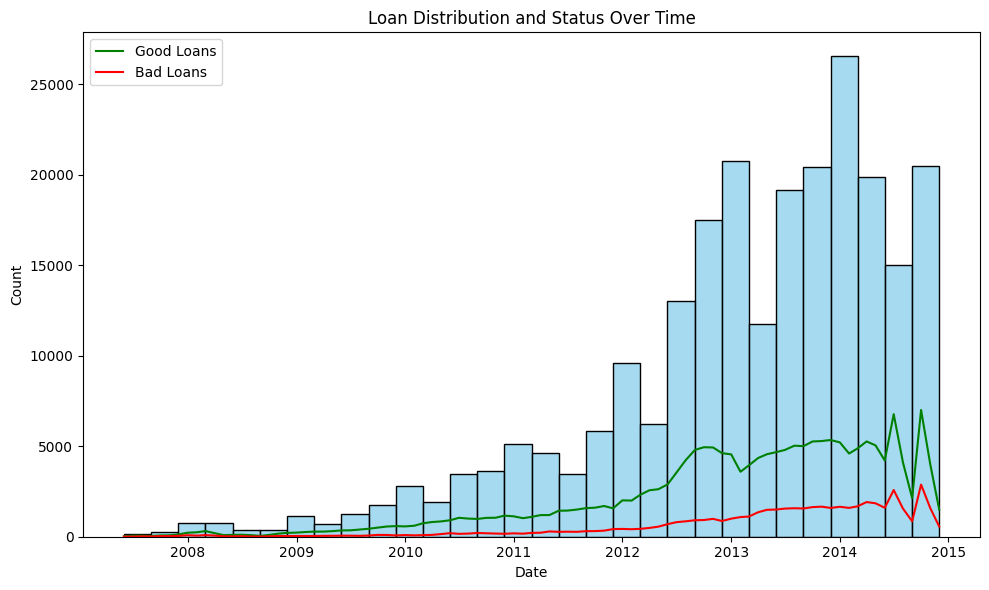

In [22]:
# Plotting
plt.figure(figsize=(10, 6))

# Histogram with loan distribution over time
sns.histplot(data=df, x='issue_d', bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Count', color='skyblue')
plt.title('Loan Distribution and Status Over Time')

# Line plot for good loans
good_loans = df[df['loan_status'] == 1].groupby('issue_d').size().reset_index(name='Count')
sns.lineplot(data=good_loans, x='issue_d', y='Count', color='green', label='Good Loans')

# Line plot for bad loans
bad_loans = df[df['loan_status'] == 0].groupby('issue_d').size().reset_index(name='Count')
sns.lineplot(data=bad_loans, x='issue_d', y='Count', color='red', label='Bad Loans')

 
#plt.axvline(pd.to_datetime('2013-07-01'), color='gray', linestyle='--', linewidth=1)


plt.ylabel('Count', color='black')
plt.legend()
plt.tight_layout()
plt.show()

# Filter issue date to determine sample window

In [25]:
train_start_date = '2010-01-01'
train_end_date = '2013-06-30'
test_start_date = '2013-07-01'
test_end_date = '2013-12-31'

In [26]:
# Split the data into (training data) and (test data)
train = df[(df['issue_d'] >= train_start_date) & (df['issue_d'] <= train_end_date)]
test = df[(df['issue_d'] >= test_start_date) & (df['issue_d'] <= test_end_date)]


print("(Training Data) Size:", len(train))
print("(Test Data) Size:", len(test))

(Training Data) Size: 115312
(Test Data) Size: 40312


In [27]:
train.drop(['issue_d'],inplace=True,axis=1)

In [28]:
X_train=train.drop('loan_status',axis=1)
y_train=train['loan_status']
X_test=test.drop('loan_status',axis=1)
y_test=test['loan_status']

# Binning

In [29]:
#specify binning requirements
combiner = toad.transform.Combiner()
combiner.fit(X_train, y_train,   method='dt', min_samples = 0.05)

bins = combiner.export()

#apply binning on both the train and test datasets
X_train = combiner.transform(X_train)
X_test = combiner.transform(X_test[X_train.columns])

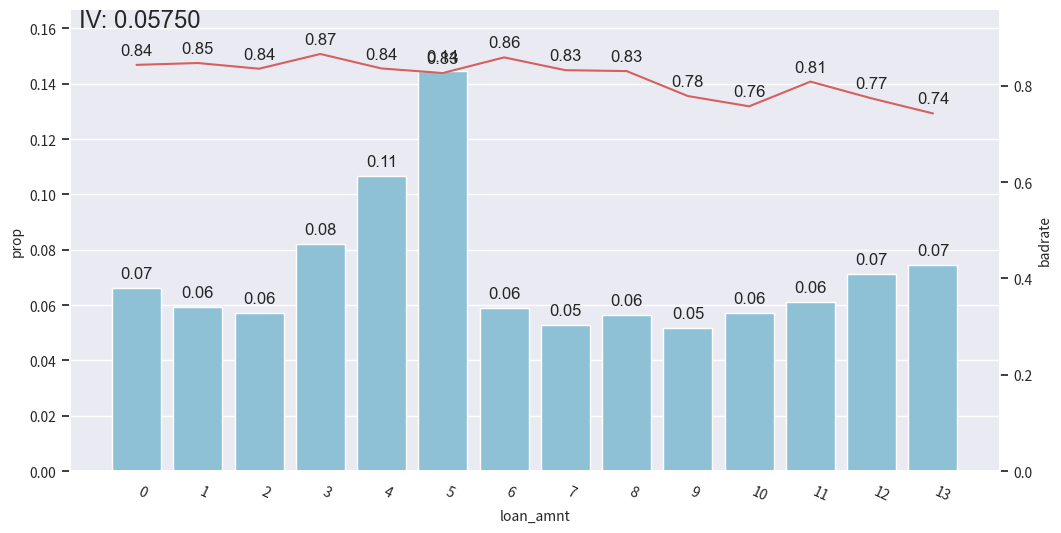

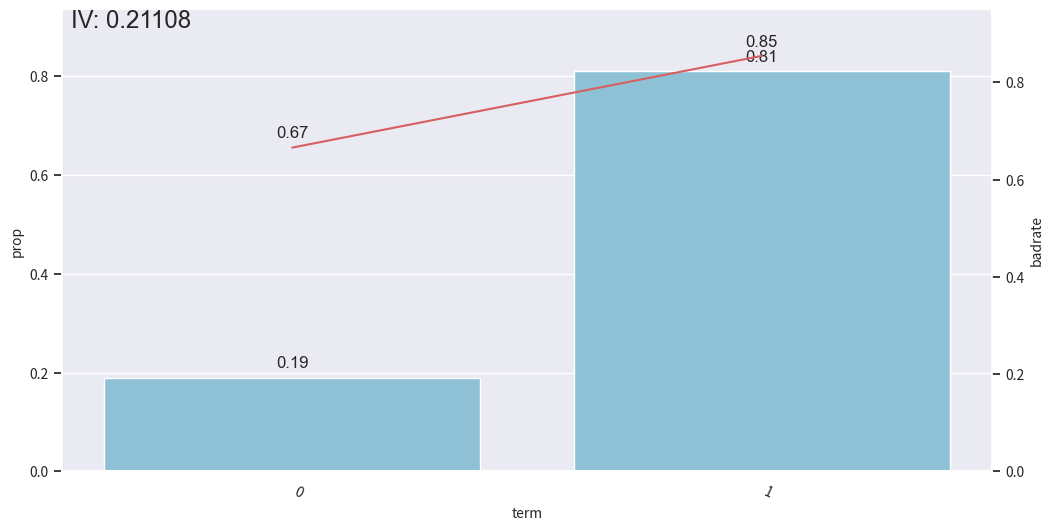

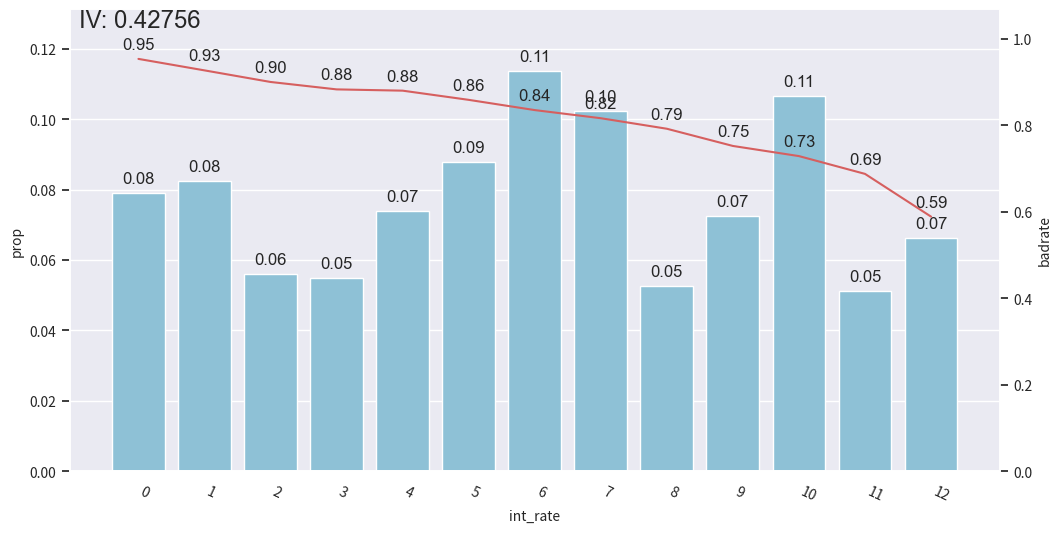

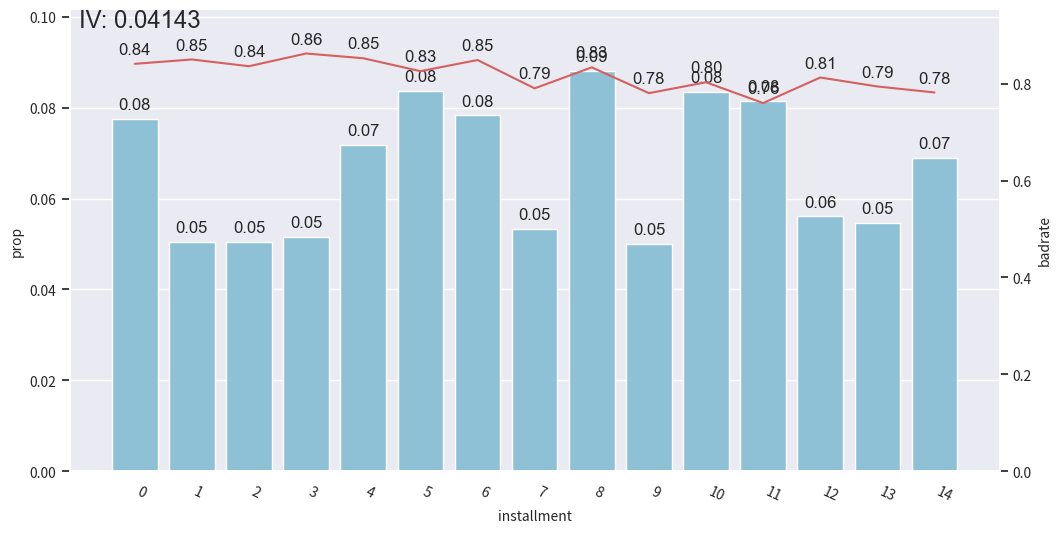

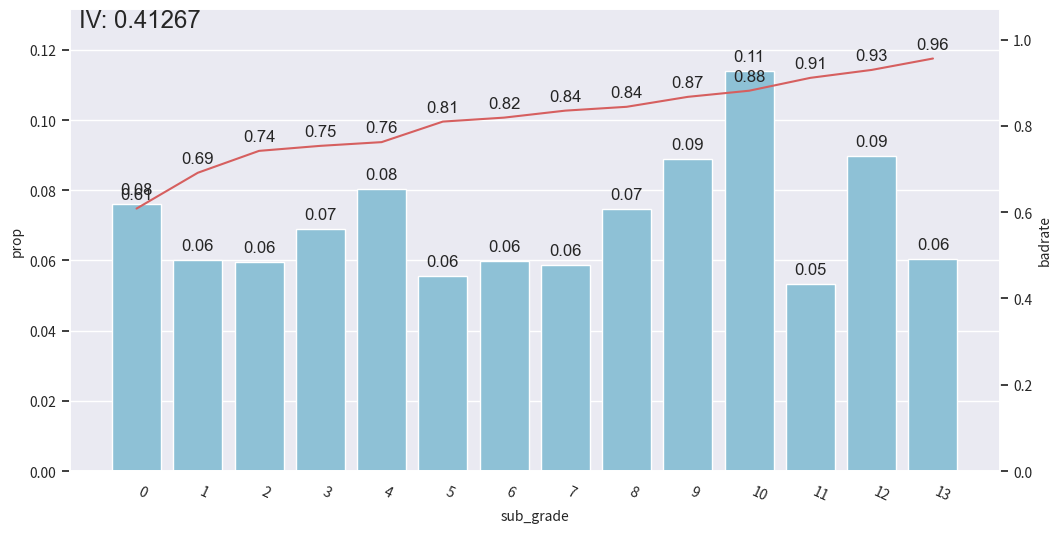

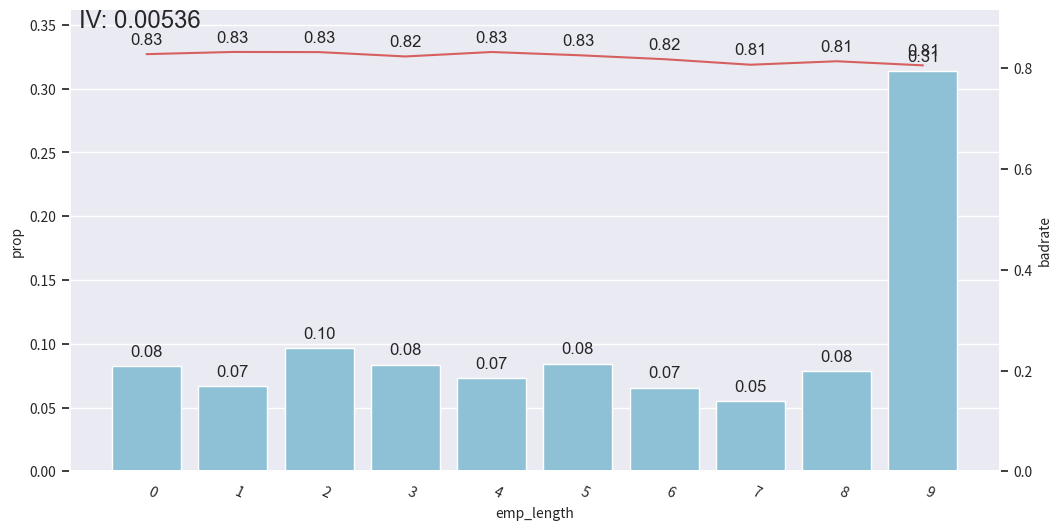

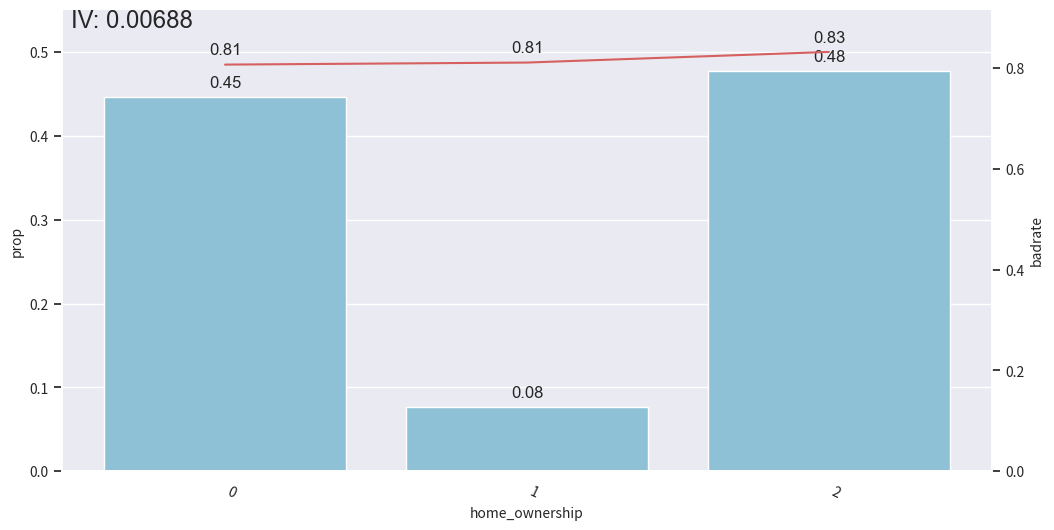

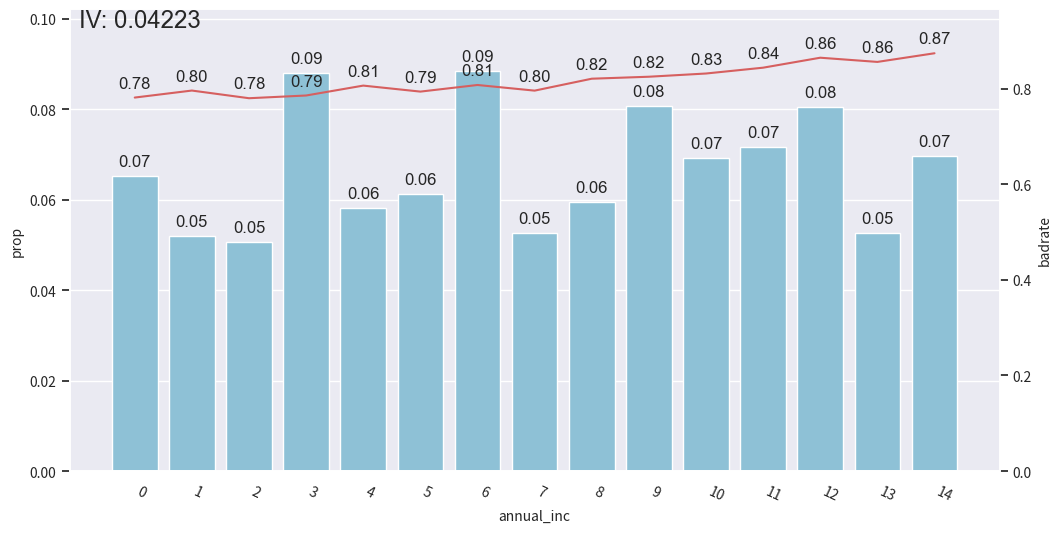

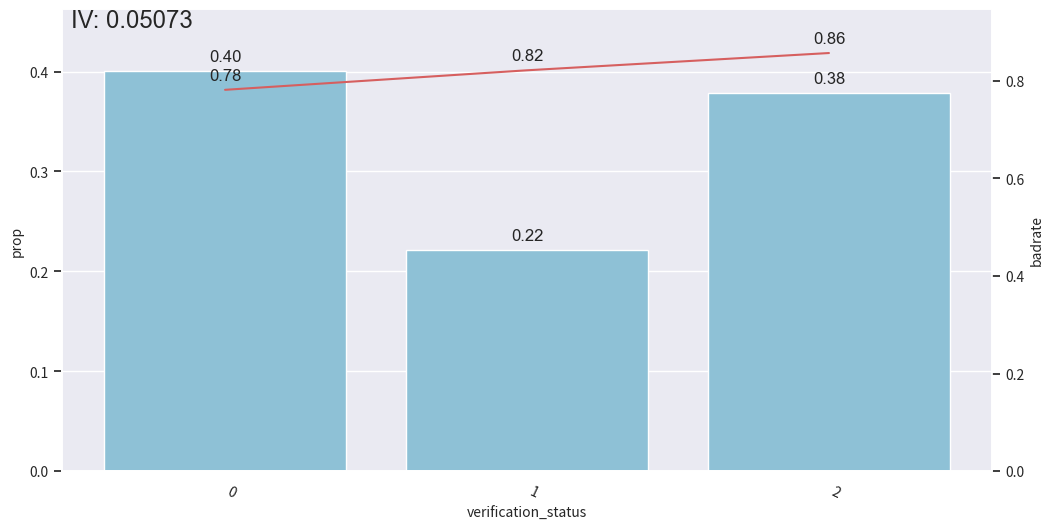

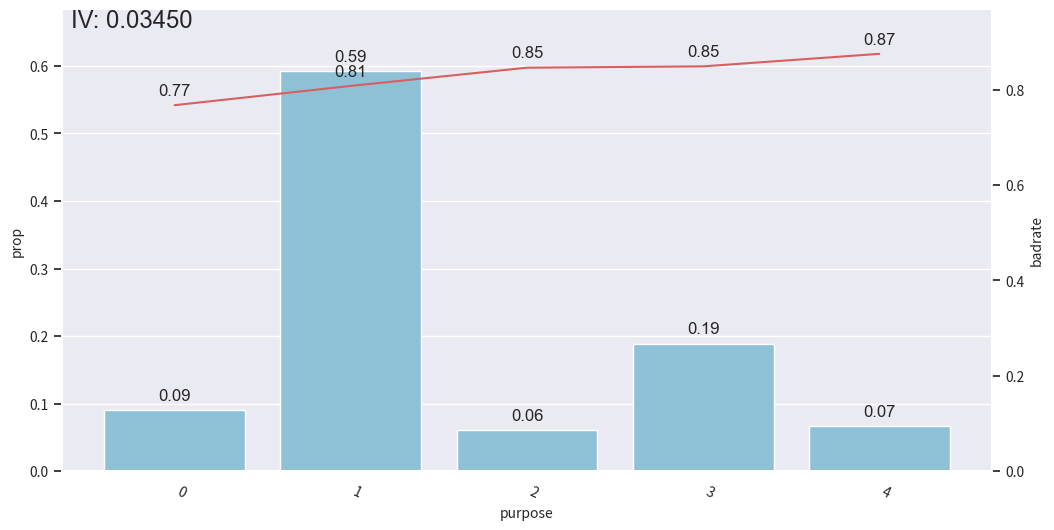

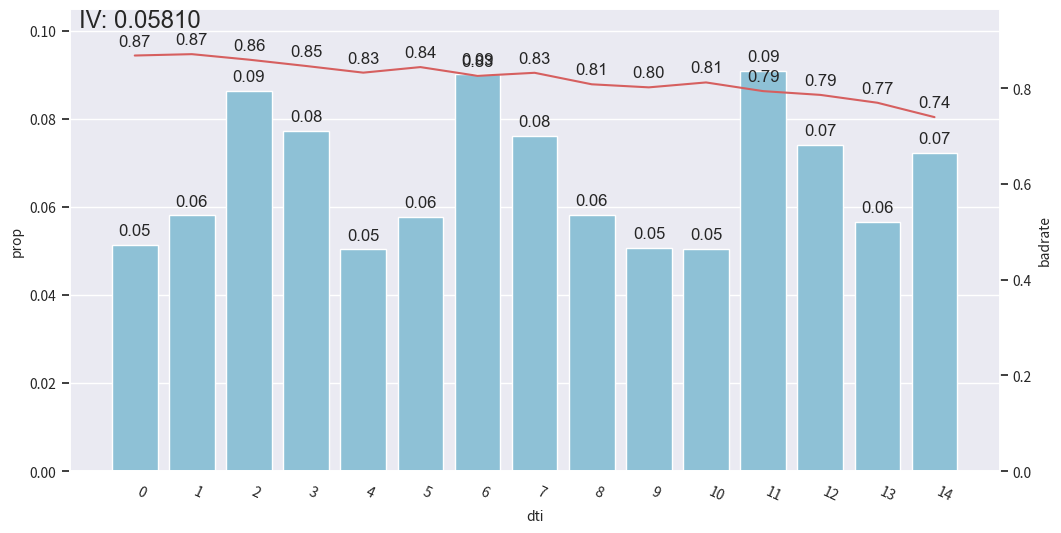

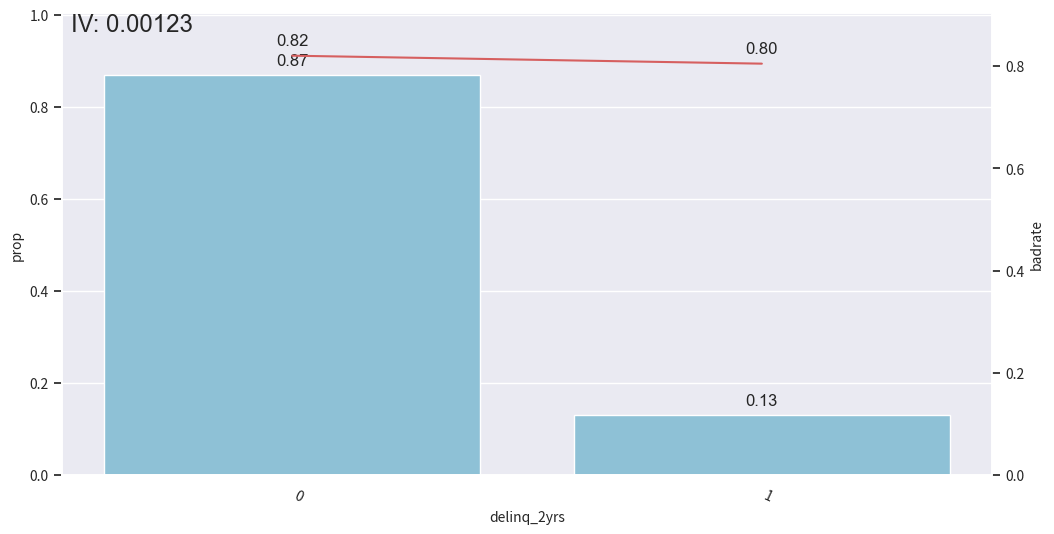

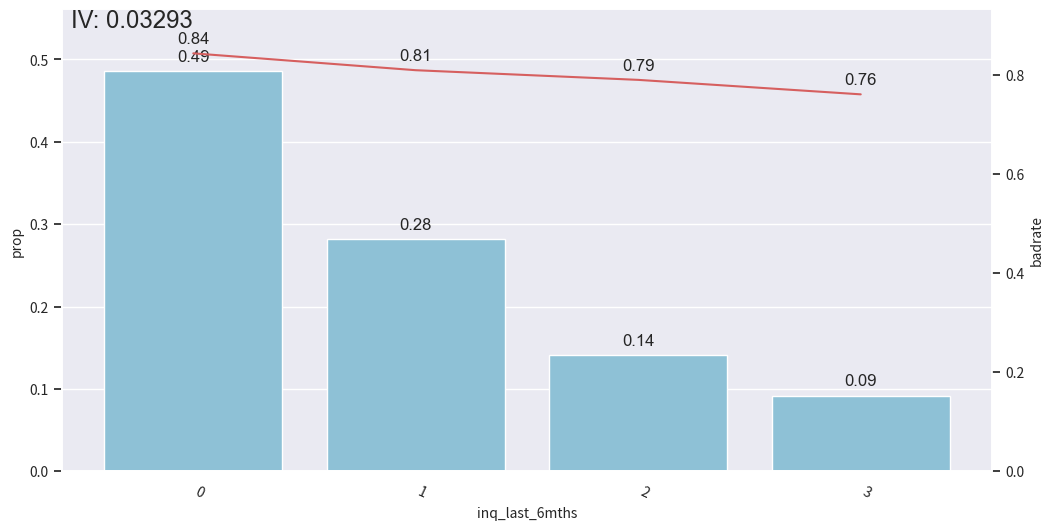

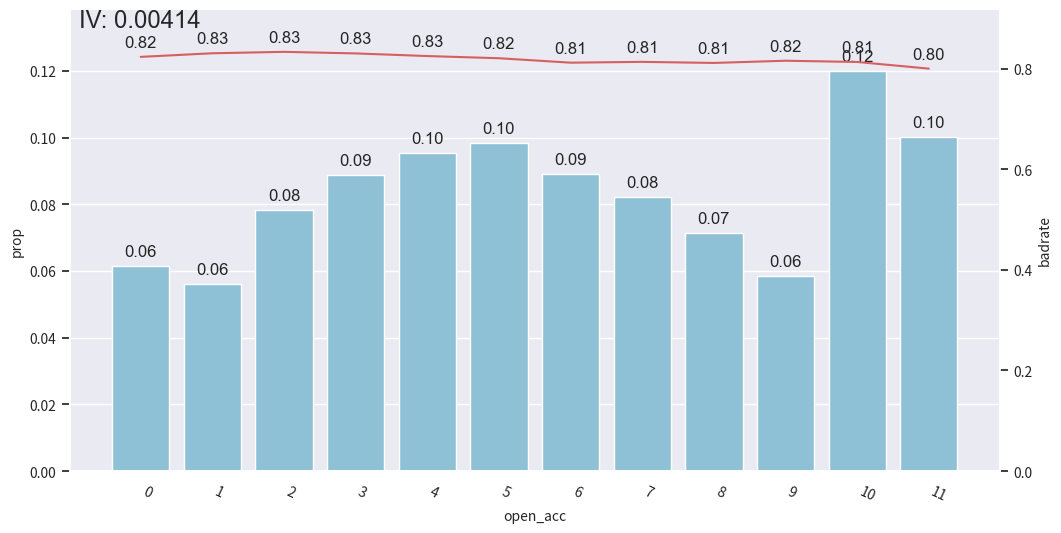

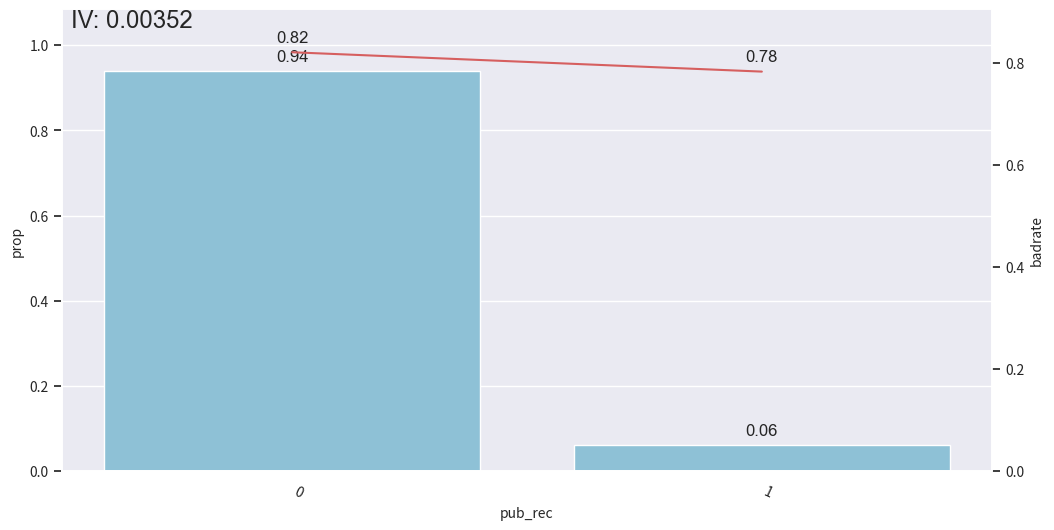

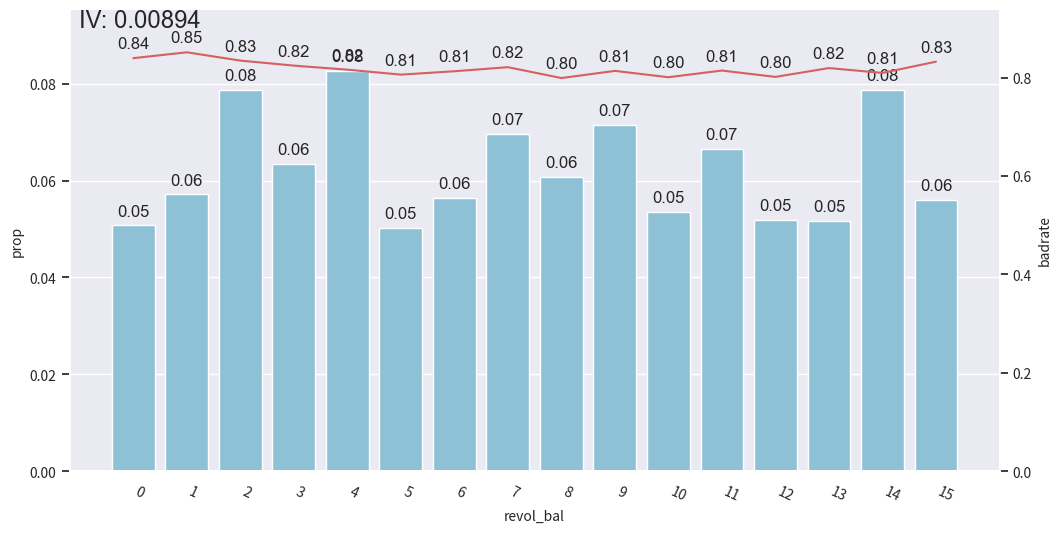

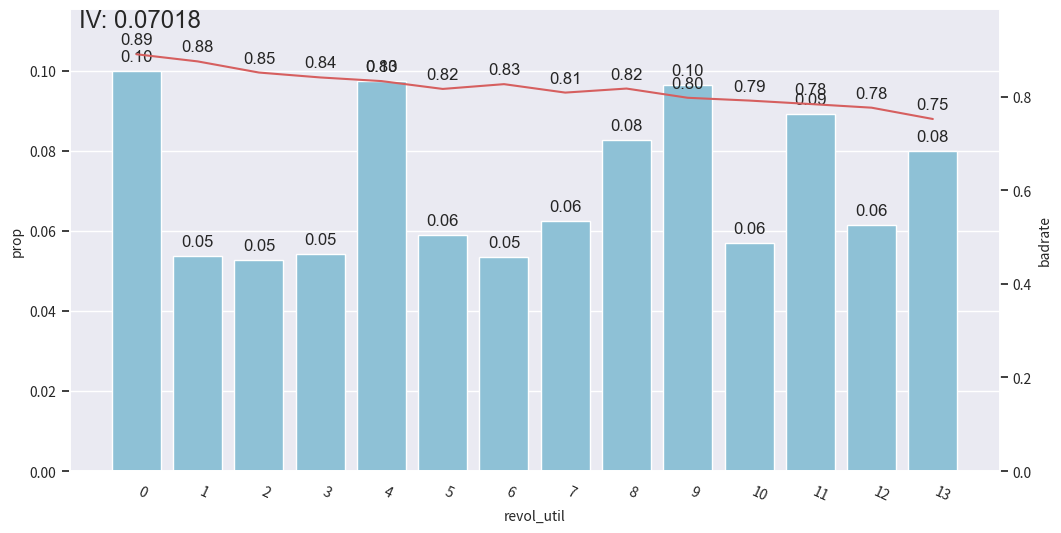

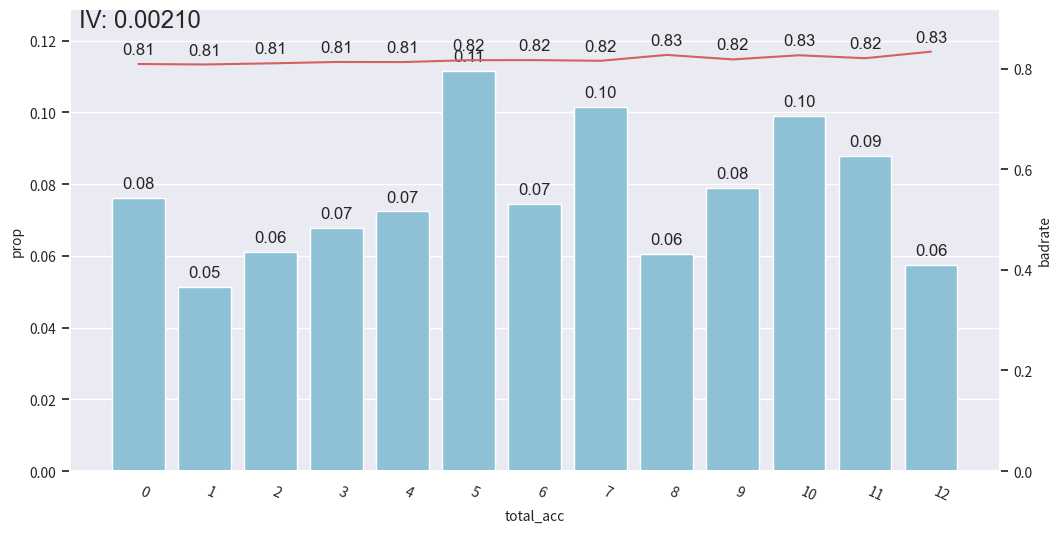

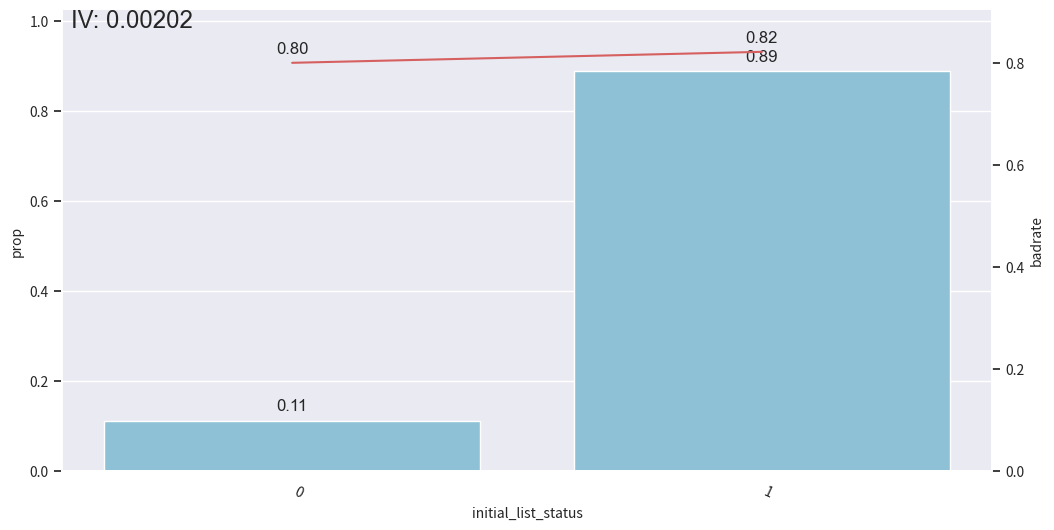

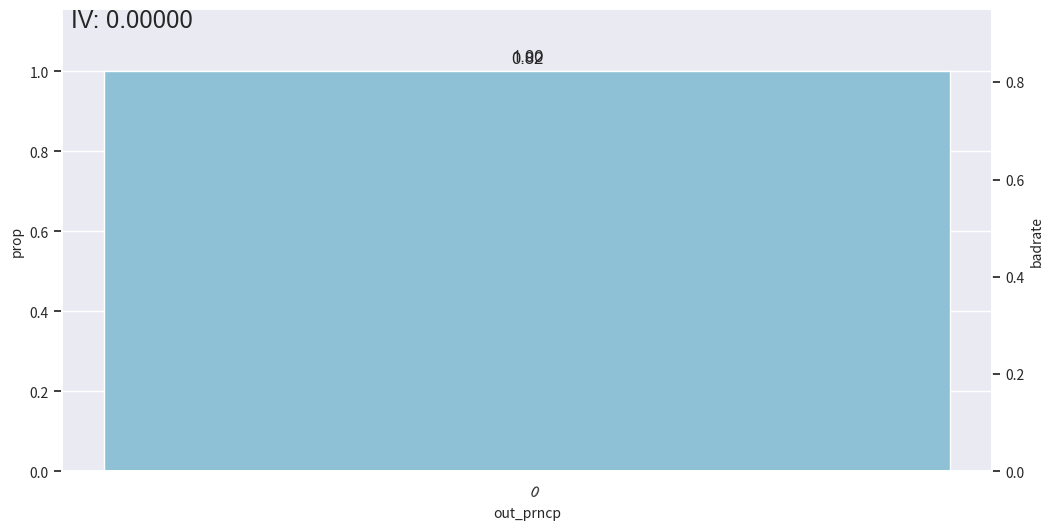

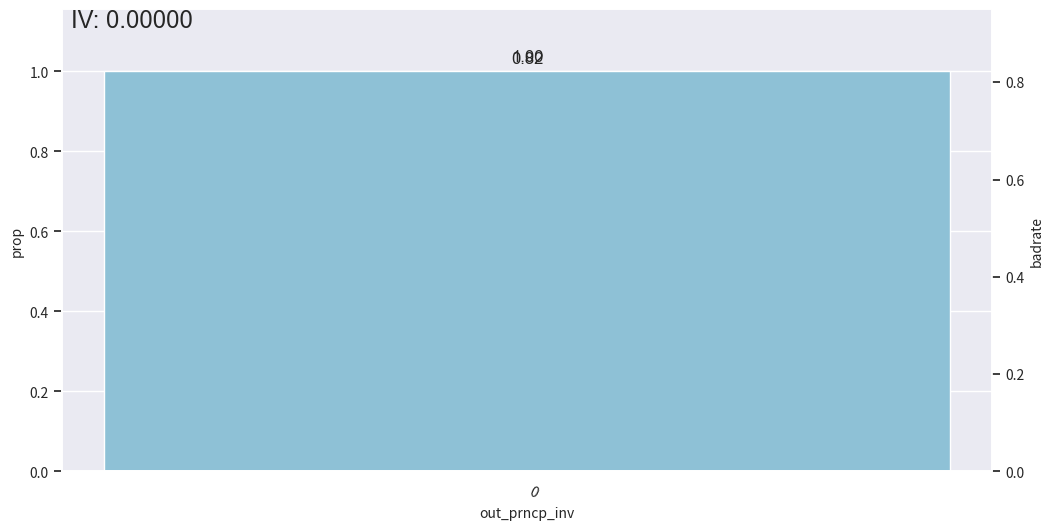

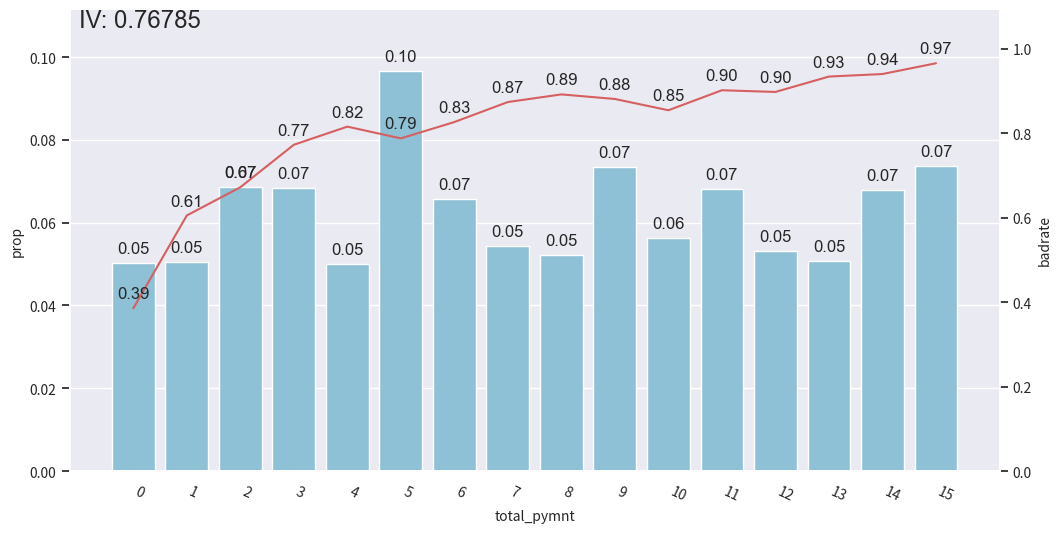

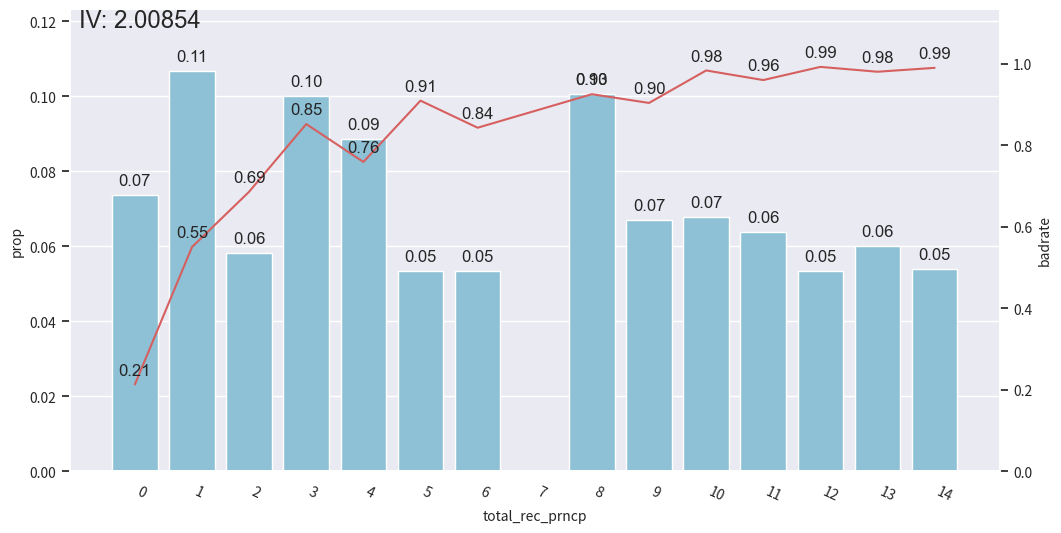

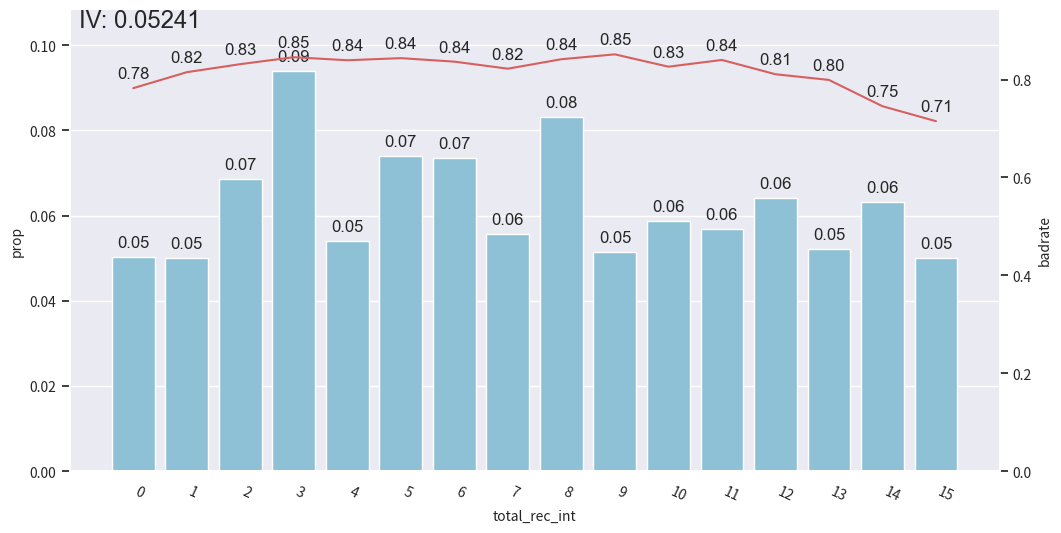

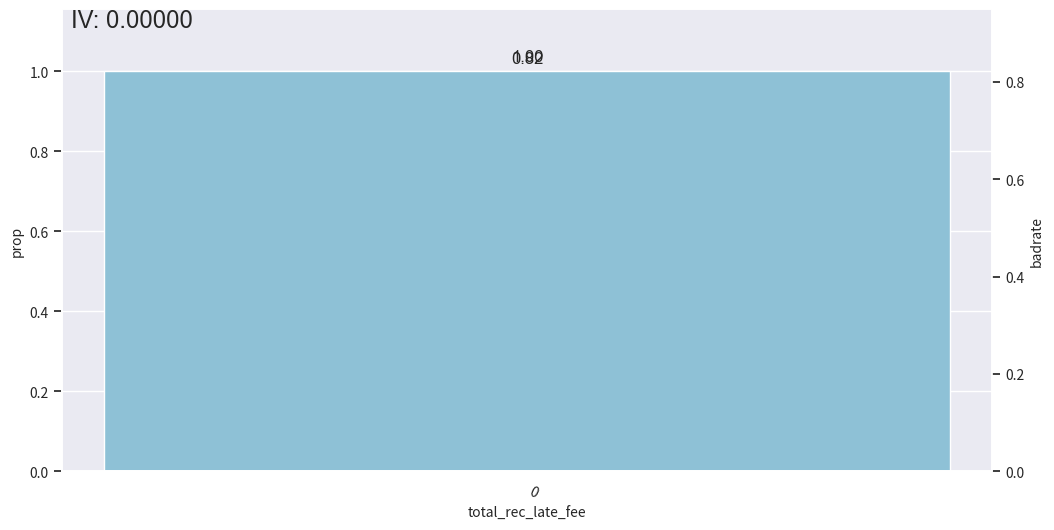

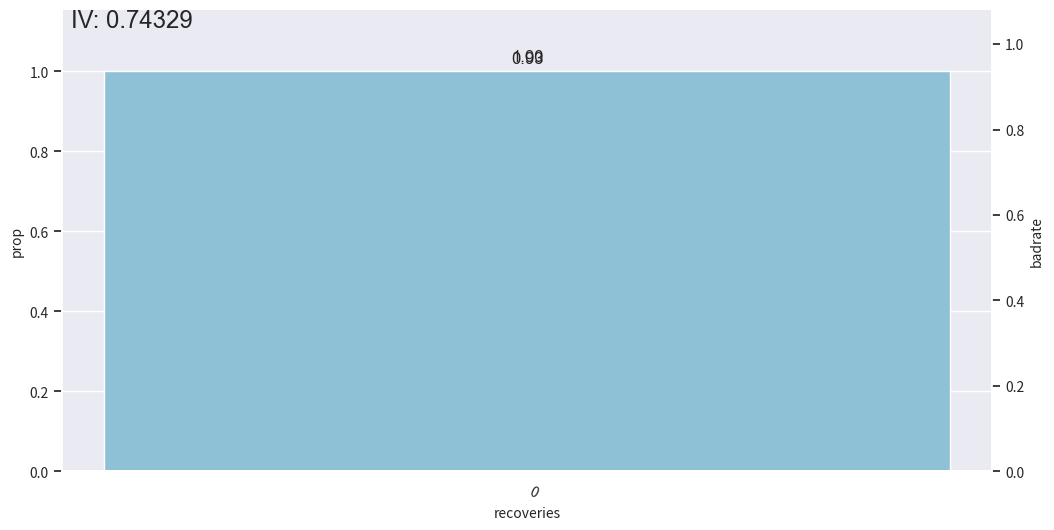

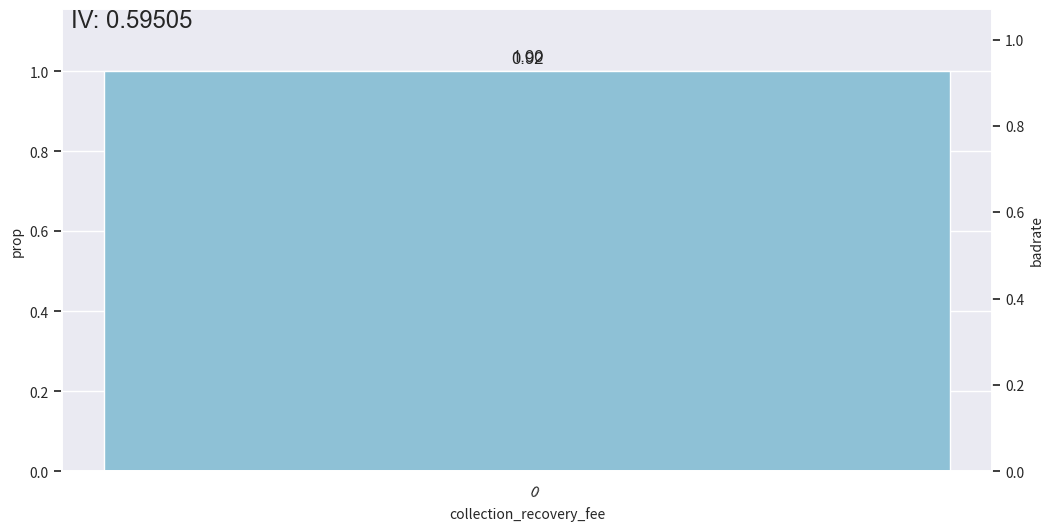

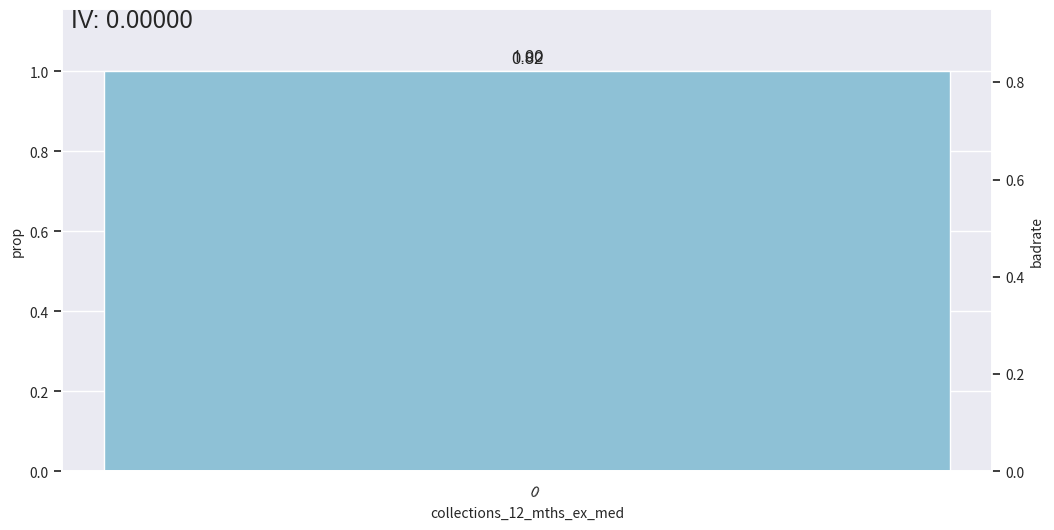

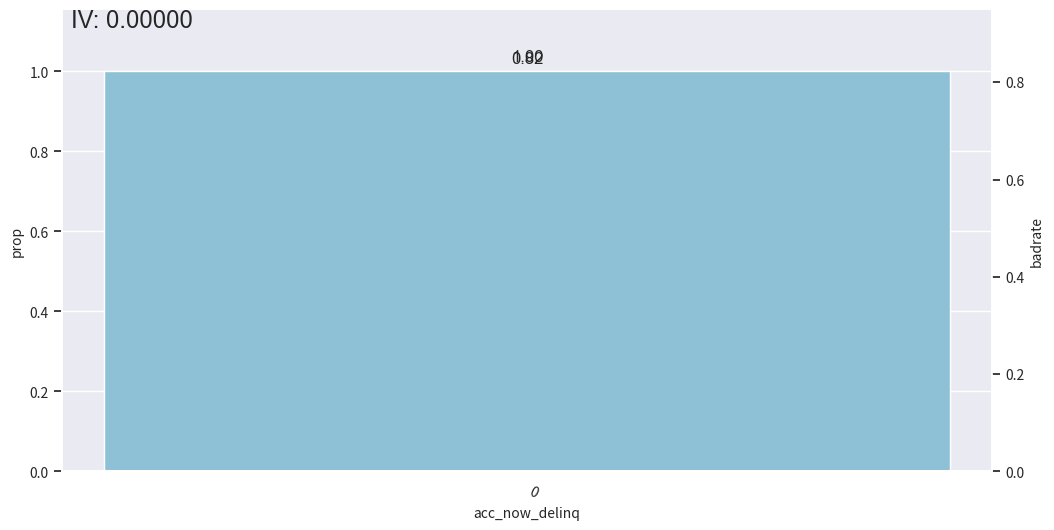

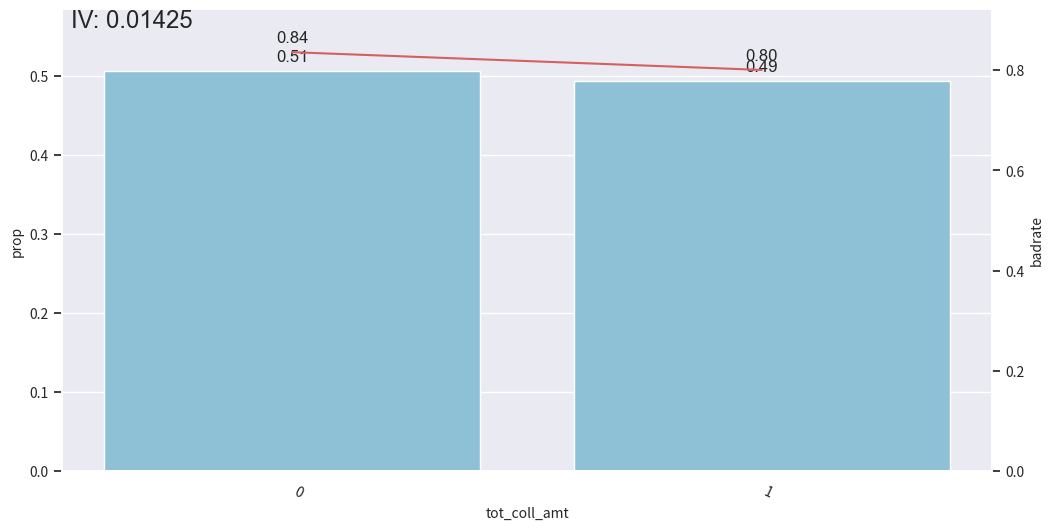

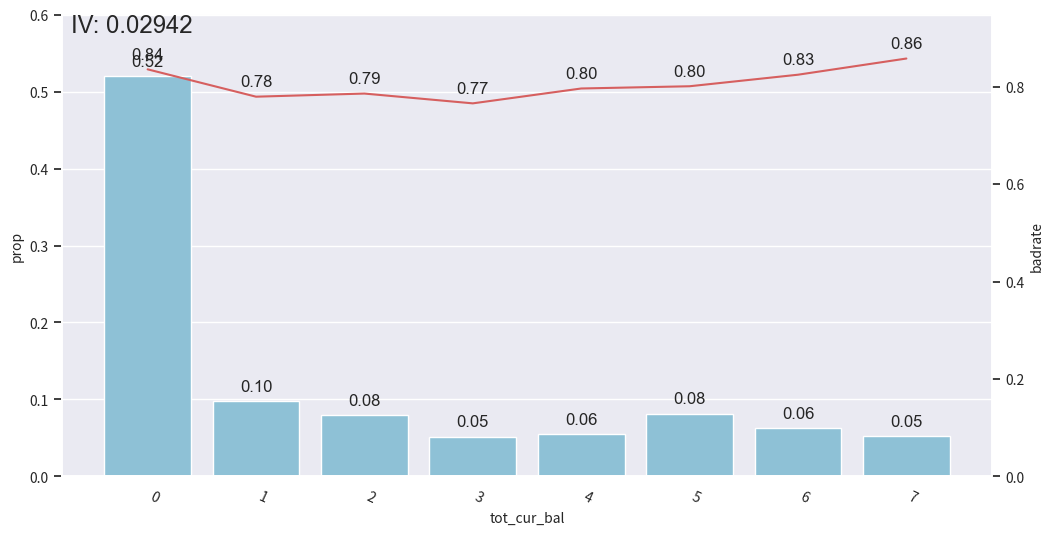

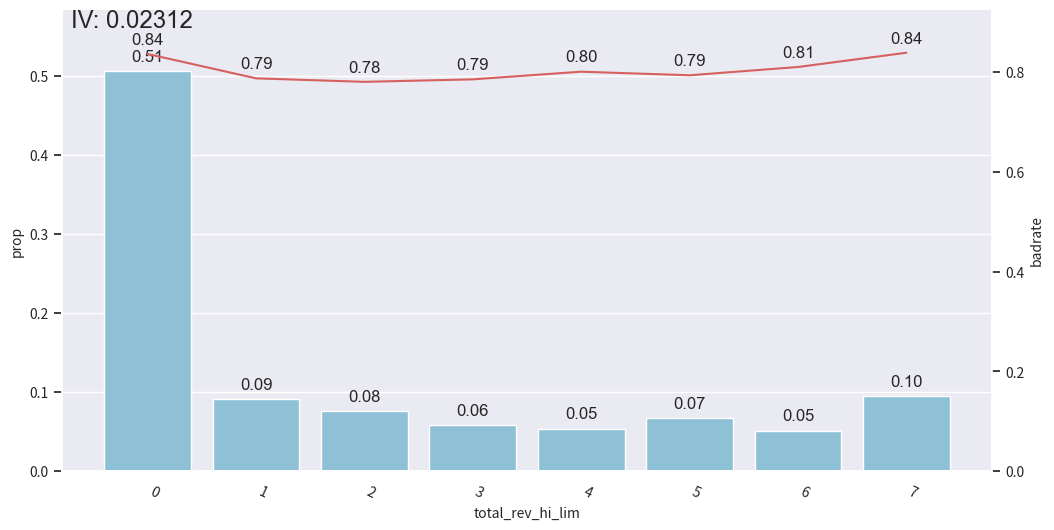

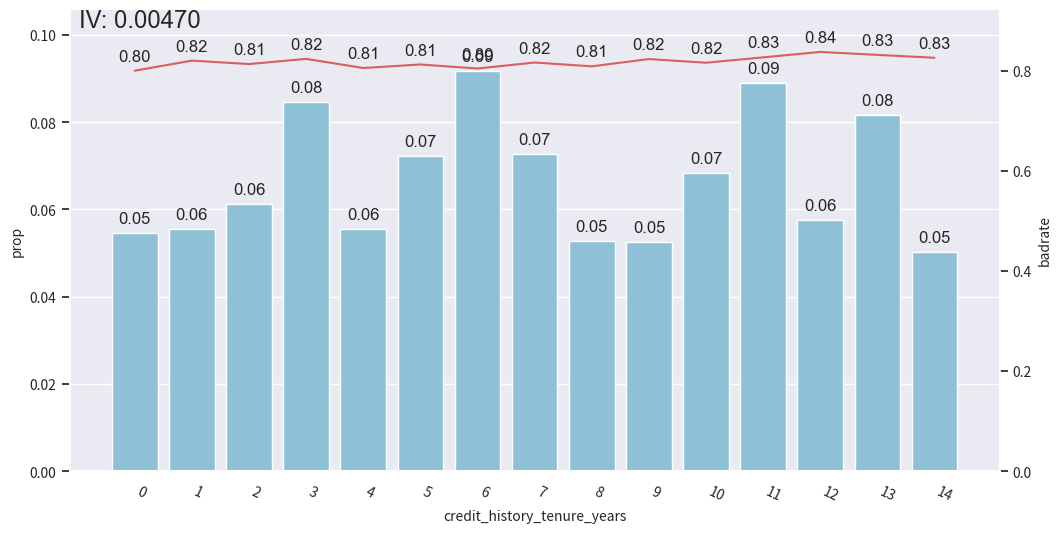

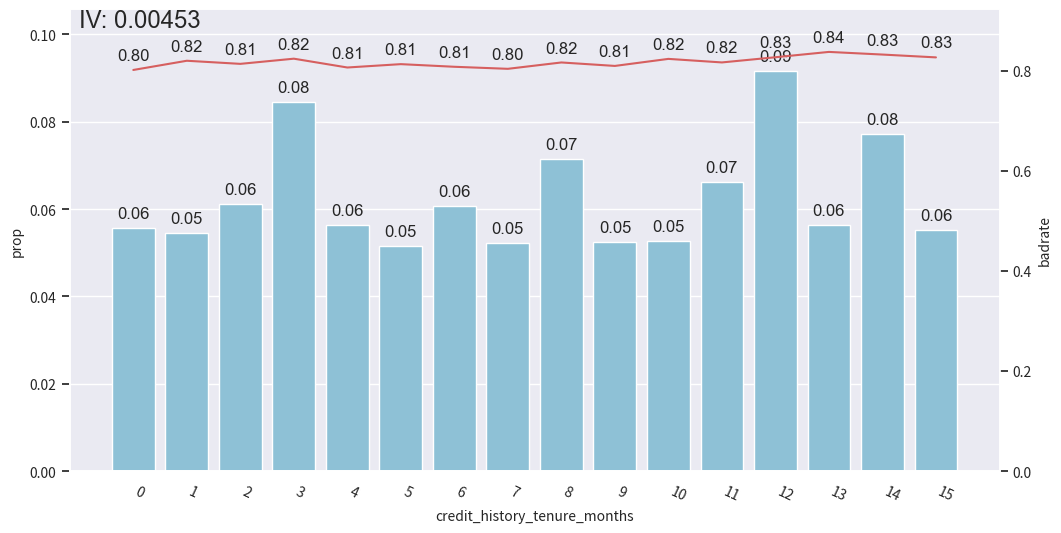

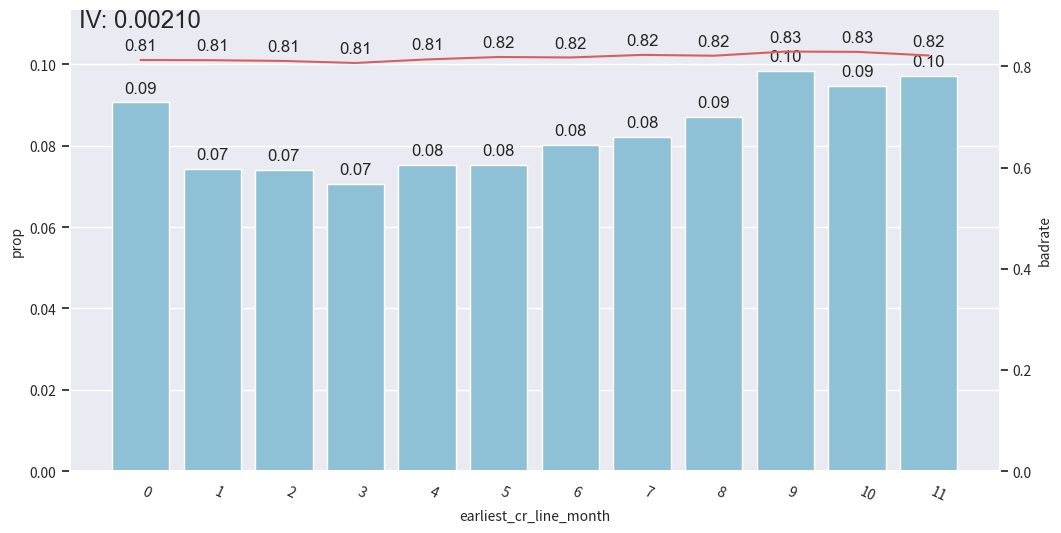

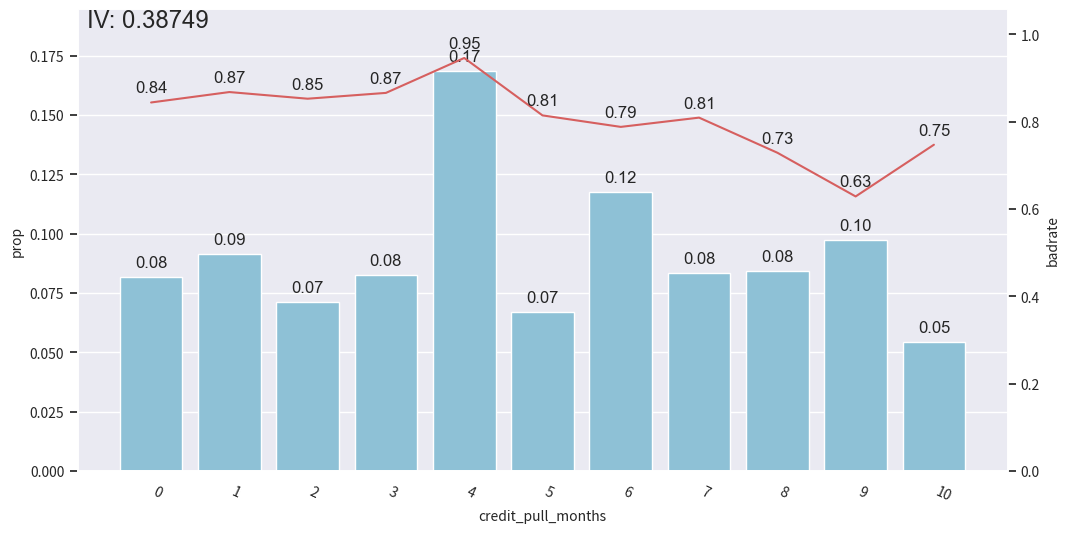

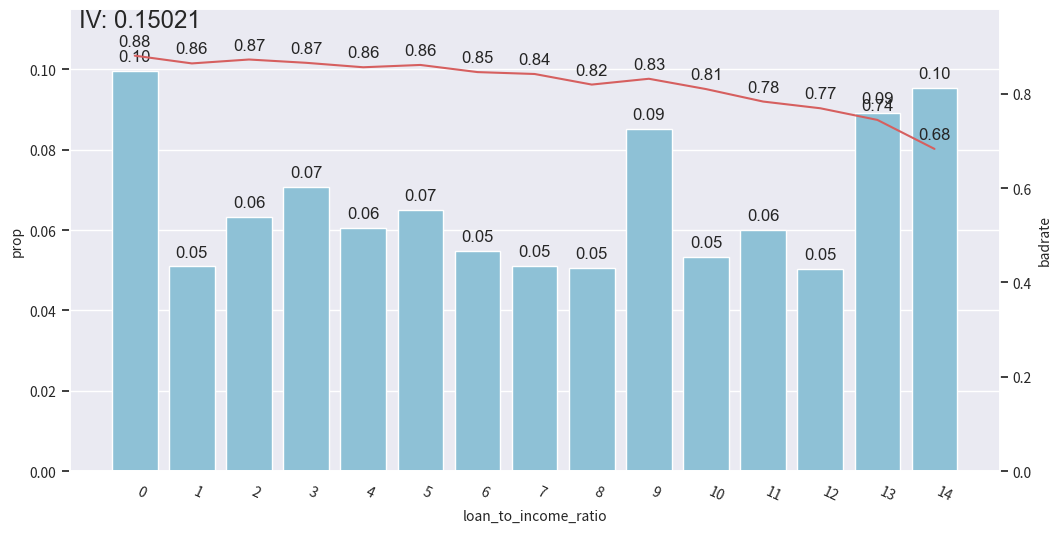

In [30]:
from toad.plot import  bin_plot
for col in X_train.columns:
    if col != 'loan_status':
        toad.plot.bin_plot(X_train, x=col, target=y_train)

In [31]:
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=X_train,
                            y=y_train)
#transform testing set
test_woe = t.transform(X_test[X_train.columns]) 

In [32]:
train_woe

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,credit_history_tenure_years,credit_history_tenure_months,earliest_cr_line_month,credit_pull_months,loan_to_income_ratio
0,0.117955,0.262746,0.488859,0.125947,0.500027,-0.083688,-0.080729,-0.233507,-0.233911,0.216810,-0.464194,0.013837,-0.061387,0.034165,0.015767,-0.032938,-0.214403,-0.057112,0.016348,0.0,0.0,-0.282923,0.244040,0.194717,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,0.095573,0.097009,-0.039811,0.376825,0.008705
1,0.177246,-0.817616,-0.168278,0.162343,-0.340975,0.064949,-0.080729,-0.145531,0.017870,0.437290,0.376762,0.013837,-0.350717,0.034165,0.015767,0.238823,0.593206,-0.057112,0.016348,0.0,0.0,-1.973808,-2.815843,0.090038,0.0,-11.054848,-10.974032,0.0,0.0,0.122622,0.123314,0.122819,-0.088675,-0.094977,-0.077572,-0.516555,0.348419
2,0.177246,0.262746,-0.395203,0.162343,-0.387960,-0.083688,-0.080729,-0.233507,0.280233,-0.313516,0.303209,0.013837,-0.183030,0.034165,0.015767,0.111546,-0.394447,-0.062987,0.016348,0.0,0.0,-1.078891,-1.305735,0.090038,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.082118,-0.078101,0.069944,0.376825,0.168674
3,0.054615,0.262746,0.117579,-0.177132,0.004088,-0.083688,-0.080729,-0.159007,0.017870,-0.313516,-0.044974,0.013837,-0.061387,-0.043165,0.015767,0.039216,0.444792,0.019516,0.016348,0.0,0.0,0.604151,7.360050,0.240175,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.013088,-0.011848,-0.042214,1.356364,0.008705
5,0.117955,0.262746,1.038432,0.125947,1.075294,0.033078,-0.080729,-0.241520,0.017870,0.437290,0.094875,0.013837,-0.350717,0.015835,0.015767,-0.082304,0.242080,-0.048595,0.016348,0.0,0.0,-0.282923,0.244040,0.194717,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.030854,-0.030854,0.069944,0.376825,0.280476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230651,0.299973,0.262746,1.038432,0.109011,1.075294,0.033078,0.088894,-0.208123,0.280233,0.216810,0.197976,0.013837,0.176320,0.015835,0.015767,-0.032938,0.057802,-0.030556,0.016348,0.0,0.0,0.496203,1.010874,0.147877,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.082118,-0.078101,-0.077572,-0.060119,-0.218369
230652,-0.065415,0.262746,-0.517476,-0.153262,-0.449638,-0.075985,-0.080729,-0.146537,0.017870,-0.071659,0.092697,-0.088642,-0.350717,-0.043165,0.015767,-0.115969,-0.063382,-0.006774,0.016348,0.0,0.0,1.247879,3.363871,-0.431331,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,0.095573,0.097009,0.073689,0.376825,-0.435079
230653,0.082774,0.262746,-0.168278,-0.351654,-0.340975,0.033078,-0.080729,-0.072310,0.017870,-0.313516,0.303209,-0.088642,-0.061387,-0.118948,0.015767,-0.038196,0.161560,0.003425,0.016348,0.0,0.0,0.665671,2.588514,-0.050488,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.030854,-0.030854,-0.039811,-0.026627,-0.054659
230654,-0.446958,0.262746,-0.395203,-0.227520,-0.387960,0.033078,0.088894,0.429454,0.017870,-0.313516,0.401763,0.013837,-0.061387,0.015835,0.015767,0.005281,-0.006578,-0.031839,0.016348,0.0,0.0,1.829637,3.092488,-0.586667,0.0,1.109130,0.962665,0.0,0.0,0.122622,0.123314,0.122819,-0.036169,-0.034587,0.017116,-0.026627,0.094431


## Information Value

In [33]:
quality=toad.quality(train_woe,target=y_train)
quality

droplist= quality[(quality['iv']<0.02) | (quality['iv']>=0.5)].index.tolist()
droplist

['recoveries',
 'collection_recovery_fee',
 'total_rec_prncp',
 'total_pymnt',
 'tot_coll_amt',
 'revol_bal',
 'home_ownership',
 'emp_length',
 'credit_history_tenure_years',
 'credit_history_tenure_months',
 'open_acc',
 'pub_rec',
 'earliest_cr_line_month',
 'total_acc',
 'initial_list_status',
 'delinq_2yrs',
 'acc_now_delinq',
 'collections_12_mths_ex_med',
 'out_prncp_inv',
 'out_prncp',
 'total_rec_late_fee']

In [34]:
train_woe.drop(columns=droplist, inplace=True)
test_woe.drop(columns=droplist, inplace=True)

In [35]:
train_woe

,loan_amnt,term,int_rate,installment,sub_grade,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,total_rec_int,tot_cur_bal,total_rev_hi_lim,credit_pull_months,loan_to_income_ratio
0,0.117955,0.262746,0.488859,0.125947,0.500027,-0.233507,-0.233911,0.216810,-0.464194,-0.061387,-0.214403,0.194717,0.123314,0.122819,0.376825,0.008705
1,0.177246,-0.817616,-0.168278,0.162343,-0.340975,-0.145531,0.017870,0.437290,0.376762,-0.350717,0.593206,0.090038,0.123314,0.122819,-0.516555,0.348419
2,0.177246,0.262746,-0.395203,0.162343,-0.387960,-0.233507,0.280233,-0.313516,0.303209,-0.183030,-0.394447,0.090038,0.123314,0.122819,0.376825,0.168674
3,0.054615,0.262746,0.117579,-0.177132,0.004088,-0.159007,0.017870,-0.313516,-0.044974,-0.061387,0.444792,0.240175,0.123314,0.122819,1.356364,0.008705
5,0.117955,0.262746,1.038432,0.125947,1.075294,-0.241520,0.017870,0.437290,0.094875,-0.350717,0.242080,0.194717,0.123314,0.122819,0.376825,0.280476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230651,0.299973,0.262746,1.038432,0.109011,1.075294,-0.208123,0.280233,0.216810,0.197976,0.176320,0.057802,0.147877,0.123314,0.122819,-0.060119,-0.218369
230652,-0.065415,0.262746,-0.517476,-0.153262,-0.449638,-0.146537,0.017870,-0.071659,0.092697,-0.350717,-0.063382,-0.431331,0.123314,0.122819,0.376825,-0.435079
230653,0.082774,0.262746,-0.168278,-0.351654,-0.340975,-0.072310,0.017870,-0.313516,0.303209,-0.061387,0.161560,-0.050488,0.123314,0.122819,-0.026627,-0.054659
230654,-0.446958,0.262746,-0.395203,-0.227520,-0.387960,0.429454,0.017870,-0.313516,0.401763,-0.061387,-0.006578,-0.586667,0.123314,0.122819,-0.026627,0.094431


## Population Stability Index(PSI)

In [51]:
psi_df=toad.metrics.PSI(train_woe,test_woe).sort_values()
psi_df=psi_df.reset_index()
psi_df=psi_df.rename(columns={'index':'feature', 0:'psi_value'})
psi_df

,feature,psi_value
0,inq_last_6mths,0.000959
1,total_rec_int,0.009029
2,term,0.017725
3,loan_to_income_ratio,0.019666
4,annual_inc,0.020385
5,dti,0.022841
6,revol_util,0.032254
7,loan_amnt,0.041573
8,verification_status,0.047121
9,installment,0.057089


In [52]:
#The industry level is to drop features with a PSI greater than 0.2
col_keep = list(set(list(psi_df[psi_df.psi_value<0.2].feature)))
train_psi = train_woe[col_keep]

print("keep:", train_psi.shape[1])



keep: 12


# Drop Highly Correlated features

In [38]:
train_psi, drop_lst = toad.selection.select(train_psi,
                                               y_train,
                                               corr=0.7, 
                                               return_drop=True, 
                                               )  
print("keep:", train_psi.shape[1],  
      "drop corr:", len(drop_lst['corr'])) 

keep: 12 drop corr: 0


## Step wise regression

In [39]:
train_stp = toad.selection.stepwise(train_psi,   y_train,  
             direction='both',   criterion='aic',  estimator='ols',intercept=False)  
print("keep:", train_stp.shape[1])

## ensure the features selected also apply to the test

test_stp = test_woe[train_stp.columns]  

keep: 11


# Train ,Test split

In [53]:
X_train, y_train = train_stp, y_train
X_test, y_test = test_stp, y_test

In [54]:
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,#
    class_weight = 'balanced', #Adjusts weights for classes if the dataset has more "good" or "bad" cases. Prevents the model from being biased toward the majority class.
    C=0.01, #Regularization strength.Smaller C means stronger regularization, preventing overfitting.
    base_score = 800, # starting score : The score given when a customer has the baseline odds
    
    base_odds = 35 ,#The odds (good:bad) corresponding to the base score.For a score of 800, the odds of good vs. bad are 35:1
    pdo = 20, #For every doubling of the odds of repayment, the score increases by 20 points.
    rate = 2 #Odds doubling rate, Tells the scorecard that a doubling of odds corresponds to the PDO value. A rate of 2 literally means "double the odds." 
)

card.fit(X_train, y_train)
final_card = card.export(to_frame=True)  


In [55]:
final_card

,name,value,score
0,term,60 months,76.18
1,term,36 months,59.29
2,purpose,"small_business,educational,renewable_energy,other",68.54
3,purpose,"debt_consolidation,moving,medical,vacation,house",64.57
4,purpose,home_improvement,60.20
...,...,...,...
112,annual_inc,[129449.5 ~ inf),51.45
113,inq_last_6mths,[-inf ~ 0.5),60.86
114,inq_last_6mths,[0.5 ~ 1.5),64.28
115,inq_last_6mths,[1.5 ~ 2.5),66.04


In [56]:
final_card.to_csv('scorecard.csv')

In [57]:
test['CreditScore'] = card.predict(X_test)

In [58]:
test.sample(10)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,credit_history_tenure_years,credit_history_tenure_months,earliest_cr_line_month,credit_pull_months,loan_to_income_ratio,CreditScore
120399,11325,36 months,7.90,354.37,A4,5.0,MORTGAGE,33000.0,Not Verified,2013-07-01,1,debt_consolidation,1.78,0.0,2.0,5.0,0.0,1214,17.3,9.0,w,0.00,0.00,11679.240000,11325.00,354.24,0.0,0.0,0.0,0.0,0.0,0.0,92642.0,7000.0,5.333333,64,3.0,-27,0.343182,641.228563
53051,10000,36 months,9.67,321.13,B1,3.0,MORTGAGE,90000.0,Not Verified,2013-12-01,1,credit_card,9.24,0.0,0.0,6.0,0.0,7935,70.2,9.0,w,0.00,0.00,11303.480000,10000.00,1303.48,0.0,0.0,0.0,0.0,0.0,0.0,248172.0,11300.0,13.585216,163,5.0,-24,0.111111,650.515449
103103,5000,36 months,11.55,165.00,B3,1.0,MORTGAGE,120000.0,Source Verified,2013-08-01,1,credit_card,9.61,2.0,1.0,7.0,0.0,12669,91.8,23.0,f,0.00,0.00,5855.359224,5000.00,855.36,0.0,0.0,0.0,0.0,0.0,0.0,375802.0,13800.0,16.000000,192,8.0,-29,0.041667,653.525926
54466,35000,36 months,17.10,1249.59,C5,2.0,MORTGAGE,130000.0,Verified,2013-12-01,1,debt_consolidation,33.12,0.0,3.0,12.0,0.0,12776,53.7,25.0,f,0.00,0.00,41791.089910,35000.00,6791.09,0.0,0.0,0.0,0.0,0.0,0.0,351623.0,23800.0,30.754278,369,3.0,-25,0.269231,641.228563
113926,10150,36 months,18.25,368.23,D2,10.0,RENT,78000.0,Verified,2013-07-01,1,debt_consolidation,8.23,1.0,1.0,12.0,1.0,7262,55.4,46.0,w,0.00,0.00,12867.740000,10150.00,2717.74,0.0,0.0,0.0,0.0,0.0,0.0,16274.0,13100.0,28.914442,347,8.0,-29,0.130128,648.355350
78034,35000,60 months,22.40,974.64,E3,6.0,MORTGAGE,105000.0,Verified,2013-10-01,0,credit_card,20.33,0.0,1.0,11.0,0.0,38496,78.4,32.0,f,24882.34,24882.34,24364.600000,10117.66,14246.94,0.0,0.0,0.0,0.0,0.0,0.0,290002.0,49129.0,27.082820,325,9.0,-27,0.333333,641.228563
83697,27050,60 months,11.99,601.58,B3,7.0,MORTGAGE,60600.0,Verified,2013-10-01,1,debt_consolidation,7.56,0.0,2.0,7.0,0.0,5248,20.2,19.0,f,0.00,0.00,32400.251310,27050.00,5350.25,0.0,0.0,0.0,0.0,0.0,0.0,216599.0,26000.0,15.832991,190,12.0,-23,0.446370,641.228563
86237,30000,36 months,16.20,1057.68,C4,3.0,MORTGAGE,86000.0,Source Verified,2013-09-01,1,credit_card,17.46,0.0,1.0,10.0,0.0,30800,78.6,17.0,f,0.00,0.00,33656.528430,30000.00,3656.53,0.0,0.0,0.0,0.0,0.0,0.0,216624.0,39200.0,12.665298,152,1.0,-28,0.348837,641.228563
51969,15000,36 months,16.99,534.72,D1,7.0,MORTGAGE,62000.0,Verified,2013-12-01,1,other,10.65,0.0,4.0,16.0,0.0,8163,20.3,32.0,w,0.00,0.00,16204.490000,15000.00,1204.49,0.0,0.0,0.0,0.0,0.0,4095.0,332694.0,40300.0,20.000000,240,12.0,-7,0.241935,641.228563
71221,7200,36 months,9.67,231.21,B1,2.0,RENT,94300.0,Source Verified,2013-11-01,1,debt_consolidation,5.59,0.0,1.0,7.0,0.0,8993,61.6,8.0,f,0.00,0.00,7670.672813,7200.00,470.67,0.0,0.0,0.0,0.0,0.0,0.0,11185.0,14600.0,5.251198,63,8.0,-26,0.076352,650.515449


In [59]:
y_test_score= card.predict(X_test)

In [60]:
bin_edges = np.arange(min(y_test_score), max(y_test_score) + 3, 3)  # Fixed bin width = 3
bin_labels = [f"{int(low)}-{int(high)}" for low, high in zip(bin_edges[:-1], bin_edges[1:])]

# Step 2: Assign Scores to Bins
score_bins = pd.cut(y_test_score, bins=bin_edges, labels=bin_labels, include_lowest=True)

# Step 3: Group by Bins and Compute Default Rate (Bad Rate)
bin_summary = pd.DataFrame({'bin': score_bins, 'target': y_test})
bin_stats = bin_summary.groupby('bin')['target'].agg(['count', 'sum'])
bin_stats['default_rate'] = (1 - bin_stats['sum'] / bin_stats['count']) * 100  # Adjusted calculation

# Display results
bin_stats

,count,sum,default_rate
bin,,,
641-644,23390,16816,28.106028
644-647,2414,1923,20.339685
647-650,2402,1962,18.318068
650-653,6936,5727,17.430796
653-656,5170,4305,16.731141


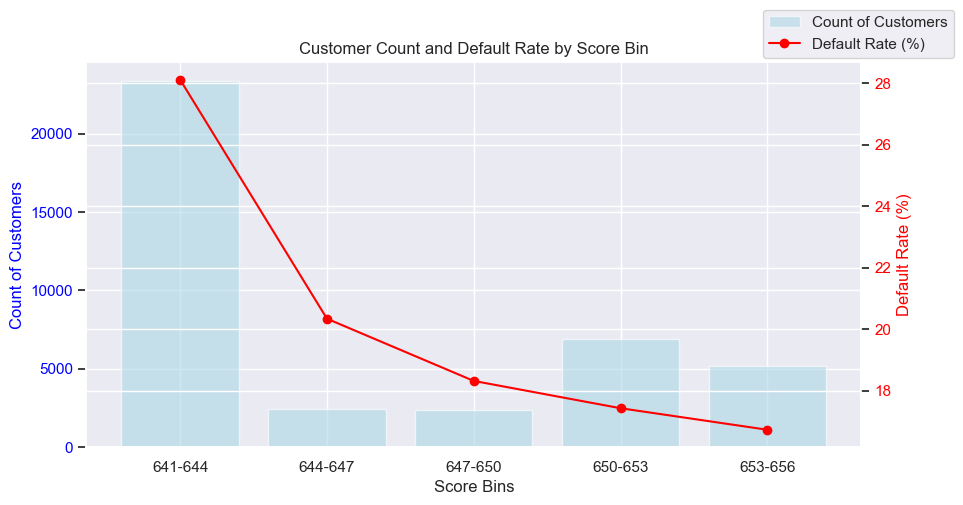

In [61]:

# Step 1: Define Fixed-Width Bins
bin_edges = np.arange(min(y_test_score), max(y_test_score) + 3, 3) 
bin_labels = [f"{int(low)}-{int(high)}" for low, high in zip(bin_edges[:-1], bin_edges[1:])]

# Step 2: Assign Scores to Bins
score_bins = pd.cut(y_test_score, bins=bin_edges, labels=bin_labels, include_lowest=True)

# Step 3: Group by Bins and Compute Default Rate (Bad Rate)
bin_summary = pd.DataFrame({'bin': score_bins, 'target': y_test})
bin_stats = bin_summary.groupby('bin')['target'].agg(['count', 'sum'])
bin_stats['default_rate'] = (1 - bin_stats['sum'] / bin_stats['count']) * 100  
bin_stats

# Step 4: Visualization
fig, ax1 = plt.subplots(figsize=(10,5))

# Bar chart for count of customers
ax1.bar(bin_stats.index.astype(str), bin_stats['count'], color='lightblue', alpha=0.6, label='Count of Customers')
ax1.set_xlabel("Score Bins")
ax1.set_ylabel("Count of Customers", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line chart for default rate
ax2 = ax1.twinx()  
ax2.plot(bin_stats.index.astype(str), bin_stats['default_rate'], color='red', marker='o', linestyle='-', label='Default Rate (%)')
ax2.set_ylabel("Default Rate (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title & Legend
plt.title("Customer Count and Default Rate by Score Bin")
fig.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.xticks(rotation=90)
plt.show()


# Evaluation

# Kolmogorov–Smirnov (KS) - Evaluation


In [62]:
# Predict scores on the test set
scores = card.predict(X_test)

# Calculate K-S statistic
ks_value = toad.metrics.KS(scores, y_test)
print(f"K-S Statistic: {ks_value:.4f}")


K-S Statistic: 0.1594


# Interpretation

- The maximum difference between the cumulative distributions of good vs. bad cases is only 15.94%, indicating that the model does not strongly differentiate between them.
- This suggests that the model might need improvement (e.g., better feature selection, different binning strategies etc).

In [63]:
from sklearn.metrics import roc_auc_score

# Generate scorecard scores
y_test_score =card.predict(X_test)  # Final credit scores

# Compute AUC
auc = roc_auc_score(y_test, y_test_score)

# Compute Gini coefficient
gini = 2 * auc - 1
print(f"Gini Coefficient (on scorecard scores): {gini:.4f}")


Gini Coefficient (on scorecard scores): 0.1776
